This file examines the Ex-vivo dataset. 

In [2]:
import os
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Loading ex-vivo data
path_to_data = "Data\\Ex-Vivo\\"
files = os.listdir(path_to_data)

files.remove("READ_ME.txt")

data = []

for file in files:
    with open(path_to_data + file, 'rb') as f:
        data.append(pickle.load(f))

In [4]:
# sorting data based on date

for d in data:
    timestamp = d['time']
    d['date'] = datetime.fromisoformat(timestamp)

data = sorted(data, key=lambda x: x['date'])

In [5]:
# Fixing labeling errors
data[51]['samplematrix'] = 'sample 7 PBS'
data[51]['conc'] = 0.0

data[52]['samplematrix'] = 'sample 8 g/PBS'
data[52]['conc'] = 2.5

data[53]['samplematrix'] = 'sample 6 g/PBS'
data[53]['conc'] = 2.5

In [6]:
#Fixing issue with sample ids due to multiple days

for d in data:
    d['samplematrix_fixed'] = d['samplematrix']

for d in data[37:]:
    values = d['samplematrix'].split()
    if len(values) > 1:
        id = int(values[1])
        new_id = id+18
        new_samplematrix = values[0] + " " + str(new_id) + " " + values[2]
        d['samplematrix_fixed'] = new_samplematrix

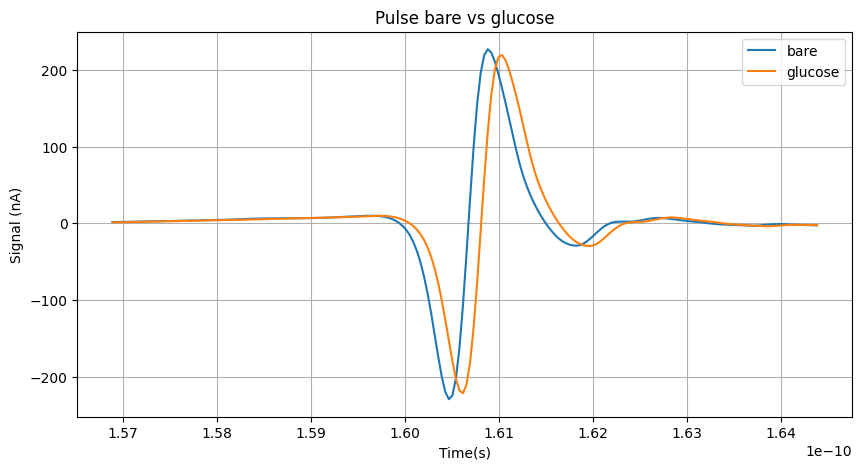

In [7]:
# Plotting pulse

x_bare = data[4]['scan'][0]['forward_scan']['time']
y_bare = data[4]['scan'][0]['forward_scan']['signal']

x_glucose = data[11]['scan'][0]['forward_scan']['time']
y_glucose = data[11]['scan'][0]['forward_scan']['signal']

min_index = np.argmin(y_bare)
max_index = np.argmax(y_bare)
middle_index = math.floor((min_index+max_index)/2)

zoom_start = middle_index - 100
zoom_end = middle_index + 100

plt.figure(figsize=(10, 5))
plt.plot(x_bare[zoom_start:zoom_end], y_bare[zoom_start:zoom_end], label='bare')
plt.plot(x_glucose[zoom_start:zoom_end], y_glucose[zoom_start:zoom_end], label='glucose')


plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Pulse bare vs glucose")
plt.legend()
plt.grid(True)
plt.show()

The pulses do not line up due to the system instability that we uncovered before. Perhaps it is easier to compare in the frequency domain?

In [8]:
from scipy.fft import rfft, rfftfreq
# Performing FFT on single signal

sample_rate_bare = 1/x_bare[1]
yf_bare = np.abs(rfft(y_bare))/(len(y_bare)/2)
xf_bare = rfftfreq(len(y_bare), 1 / sample_rate_bare) * (10**(-12)) # We multiply with 10**-12 to get terahertz as unit

sample_rate_glucose = 1/x_glucose[1]
yf_glucose = np.abs(rfft(y_glucose))/(len(y_glucose)/2)
xf_glucose = rfftfreq(len(y_glucose), 1 / sample_rate_glucose) * (10**(-12))

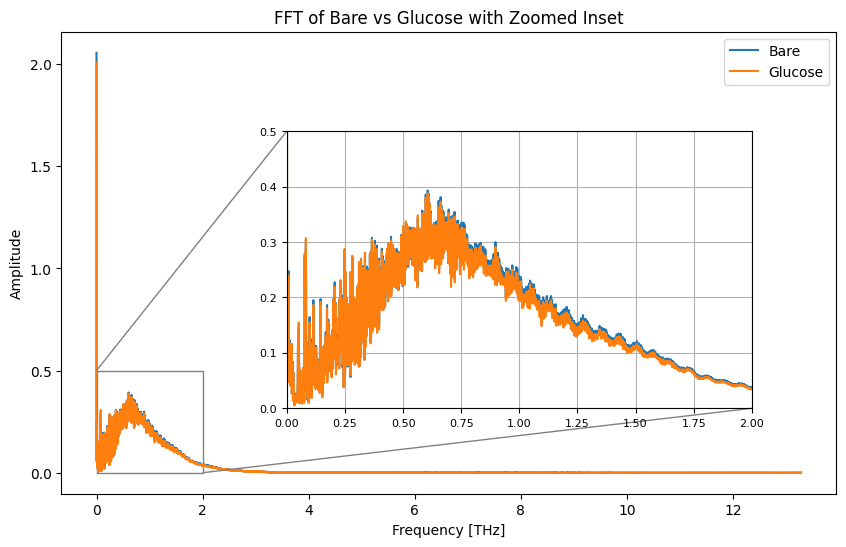

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(xf_bare, yf_bare, label='Bare')
ax.plot(xf_glucose, yf_glucose, label='Glucose')

ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('Amplitude')
ax.set_title('FFT of Bare vs Glucose with Zoomed Inset')

inset_ax = inset_axes(ax, width="150%", height="150%", loc='upper right',
                      bbox_to_anchor=(0.5, 0.4, 0.4, 0.4),
                      bbox_transform=ax.transAxes)

inset_ax.plot(xf_bare, yf_bare, label='Bare')
inset_ax.plot(xf_glucose, yf_glucose, label='Glucose')

# defining the zoom
inset_ax.set_xlim(0, 2)  
inset_ax.set_ylim(0, .5)  

inset_ax.grid(True)

inset_ax.tick_params(axis='both', which='major', labelsize=8)

mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend()

plt.show()

In [10]:
# Creating the dataset for PCA and ml models
X = []
y = []
y_days = []
y_date = []

for d in data:
    for pulse in d['scan']:
        X.append(pulse['forward_scan']['signal'])
        if(len(d['samplematrix'].split()) > 1):
            d_class = d['samplematrix'].split()[2]
        else:
            d_class = 'air'
        
        y.append(d_class)
        y_days.append(d['date'].day)
        y_date.append(d['date'])

In [11]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=None) # Keeping all

pca.fit(X)

PCA()

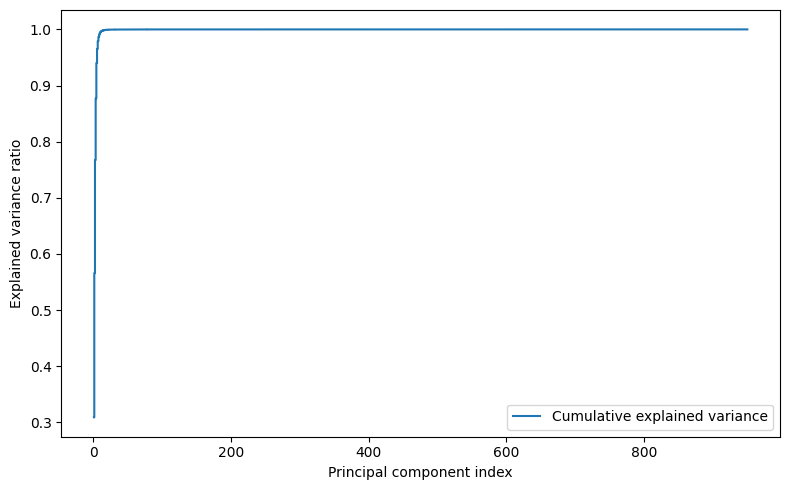

Number of components needed to explain 95.0% of variance is 6
First 2 components explain 56.56534966143969% of variance


In [12]:
explained_variance = pca.explained_variance_ratio_

cumulitive_explained_vairance = 0
most_important_components = []

required_variance_explained = .95

for i, component in enumerate(explained_variance):
    if cumulitive_explained_vairance > required_variance_explained:
        break
    cumulitive_explained_vairance += component
    most_important_components.append(pca.components_[i])



# Plotting the explained variance
plt.figure(figsize=(8, 5))
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(f"Number of components needed to explain {required_variance_explained*100}% of variance is {len(most_important_components)}")
print(f"First 2 components explain {(explained_variance[0] + explained_variance[1])*100}% of variance")

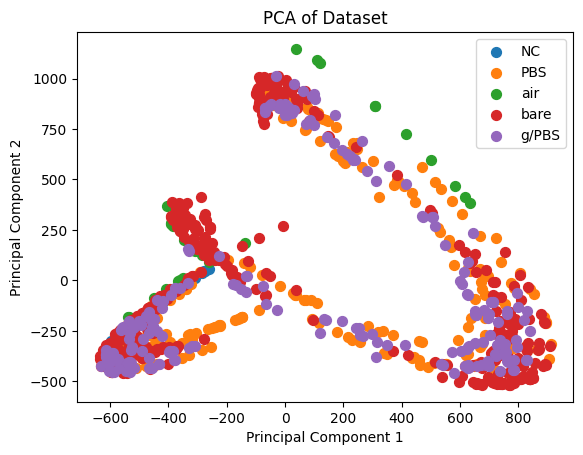

In [13]:
# Now we want to redo but only keep the first 2 components

pca = PCA(n_components=2) 
pca.fit(X)

data_pca = pca.transform(X)

unique_classes = np.unique(y)
for cls in unique_classes:
    # Selecting data points that belong to the current class
    ix = [i for i in range(len(y)) if y[i] == cls]
    plt.scatter(data_pca[ix, 0], data_pca[ix, 1], label=cls, s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')

plt.legend()

plt.show()

Seems there are two distinct shapes. it is worthwhile to explore further the cause of this. Perhaps the reason is due to the samlpes being taken on two different days?

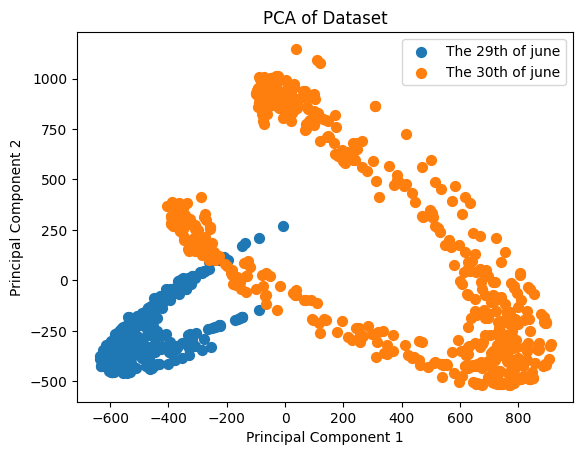

In [14]:
# Plotting again but colorcoded using date instead of class
unique_classes = np.unique(y_days)
for cls in unique_classes:
    # Selecting data points that belong to the current class
    ix = [i for i in range(len(y_days)) if y_days[i] == cls]
    plt.scatter(data_pca[ix, 0], data_pca[ix, 1], label=f"The {cls}th of june", s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')

plt.legend()

plt.show()

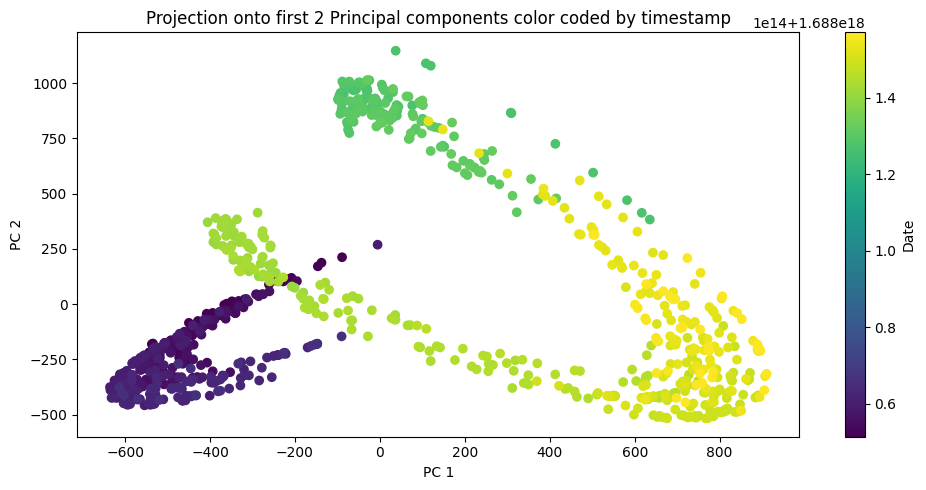

In [15]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


dates = pd.to_datetime(y_date)

colors = dates.astype(np.int64)  


norm = Normalize(vmin=colors.min(), vmax=colors.max())


cmap = plt.get_cmap('viridis')


sm = ScalarMappable(norm=norm, cmap=cmap)


fig, ax = plt.subplots(figsize = (10, 5))


scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=colors, cmap=cmap, norm=norm)


cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Date')


ax.set_title('Projection onto first 2 Principal components color coded by timestamp')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.tight_layout()
plt.show()


There is some type of gradient, however, i am not sure how to interpret it. Is the first 2 components actually capturing the different dates?

It seems like the first 2 components have captured the systematical errors over the two different days. 
This can be used in the report as argument for normalization. But make sure that this is actually true

But what is the reason for these shapes in particular? Perhaps ask Marjan. 

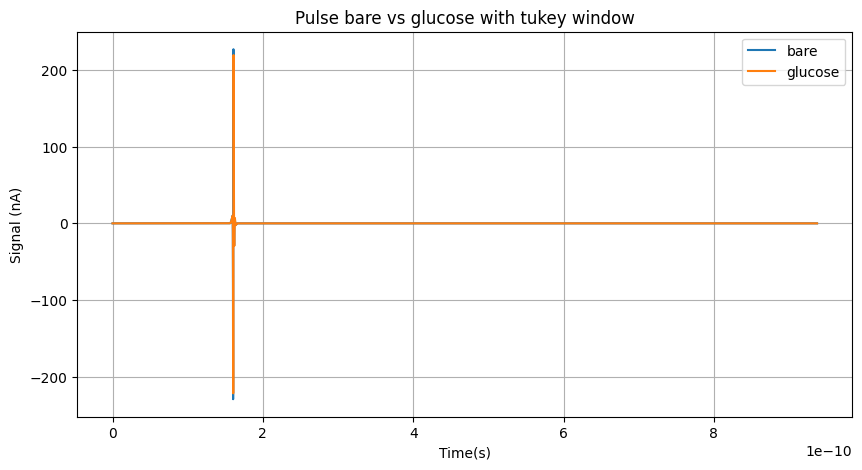

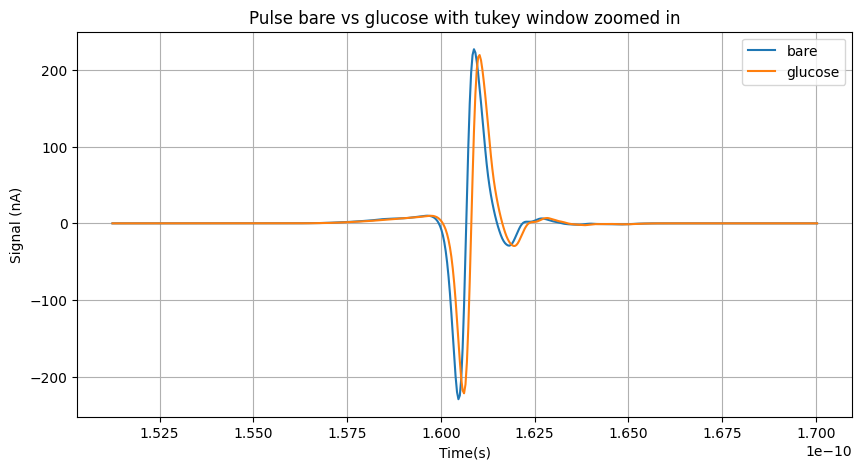

In [30]:
# Doing FFT but with using tukey window to remove a lot of noise.
from scipy.signal.windows import tukey


x_bare = data[4]['scan'][0]['forward_scan']['time']
y_bare = data[4]['scan'][0]['forward_scan']['signal']

x_glucose = data[11]['scan'][0]['forward_scan']['time']
y_glucose = data[11]['scan'][0]['forward_scan']['signal']

min_index_bare = np.argmin(y_bare)
max_index_bare = np.argmax(y_bare)
middle_index_bare = math.floor((min_index_bare+max_index_bare)/2)

min_index_glucose = np.argmin(y_glucose)
max_index_glucose = np.argmax(y_glucose)
middle_index_glucose = math.floor((min_index_glucose+max_index_glucose)/2)

window_start_bare = middle_index_bare - 150
window_end_bare = middle_index_bare + 150

window_start_glucose = middle_index_glucose - 150
window_end_glucose = middle_index_glucose + 150

window_bare = tukey(window_end_bare-window_start_bare, alpha = 0.8)
windowed_signal_bare = y_bare[window_start_bare: window_end_bare] * window_bare
y_bare = np.zeros(len(y_bare), dtype=float)
y_bare[window_start_bare: window_end_bare] = windowed_signal_bare

window_glucose = tukey(window_end_glucose-window_start_glucose, alpha = 0.8)
windowed_signal_glucose = y_glucose[window_start_glucose: window_end_glucose] * window_glucose
y_glucose = np.zeros(len(y_glucose), dtype=float)
y_glucose[window_start_glucose: window_end_glucose] = windowed_signal_glucose

plt.figure(figsize=(10, 5))
plt.plot(x_bare, y_bare, label='bare')
plt.plot(x_glucose, y_glucose, label='glucose')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Pulse bare vs glucose with tukey window")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x_bare[window_start_bare-100: window_end_bare+100], y_bare[window_start_bare-100: window_end_bare+100], label='bare')
plt.plot(x_glucose[window_start_bare-100: window_end_bare+100], y_glucose[window_start_bare-100: window_end_bare+100], label='glucose')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Pulse bare vs glucose with tukey window zoomed in")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Performing FFT on tukey version of signal

sample_rate_bare = 1/x_bare[1]
yf_bare = np.abs(rfft(y_bare))/(len(y_bare)/2)
xf_bare = rfftfreq(len(y_bare), 1 / sample_rate_bare) * (10**(-12)) # We multiply with 10**-12 to get terahertz as unit

sample_rate_glucose = 1/x_glucose[1]
yf_glucose = np.abs(rfft(y_glucose))/(len(y_glucose)/2)
xf_glucose = rfftfreq(len(y_glucose), 1 / sample_rate_glucose) * (10**(-12))

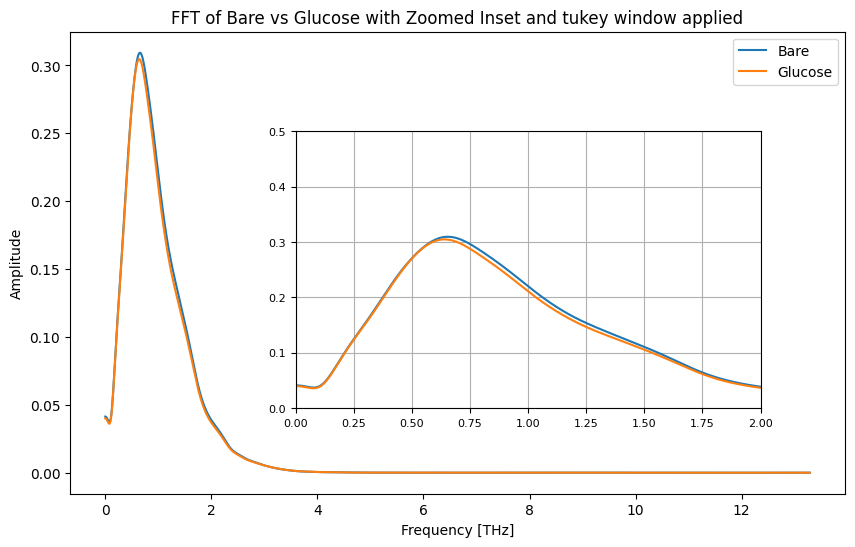

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(xf_bare, yf_bare, label='Bare')
ax.plot(xf_glucose, yf_glucose, label='Glucose')

ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('Amplitude')
ax.set_title('FFT of Bare vs Glucose with tukey window applied')


inset_ax = inset_axes(ax, width="150%", height="150%", loc='upper right',
                      bbox_to_anchor=(0.5, 0.4, 0.4, 0.4),
                      bbox_transform=ax.transAxes)

inset_ax.plot(xf_bare, yf_bare, label='Bare')
inset_ax.plot(xf_glucose, yf_glucose, label='Glucose')

# defining the zoom
inset_ax.set_xlim(0, 2)  
inset_ax.set_ylim(0, .5)  

inset_ax.grid(True)

inset_ax.tick_params(axis='both', which='major', labelsize=8)

ax.legend()

plt.show()